In [1]:
max_words = 2000
max_len = 40
num_classes = 1

# Training
epochs = 10
batch_size = 512
print_batch_n = 100

In [2]:
import pandas as pd

df_train = pd.read_csv("/content/sample_data/train.csv")
df_test = pd.read_csv("/content/sample_data/test.csv")

In [3]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


### Предобработка

In [6]:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=5c1406e7f8e0d6018ee3b8e6e8f7271979c98c64a7690b86b949911f16633610
  Stored in directory: /root/.cache/pip/wheels/da/d8/66/395317506a23a9d1d7de433ad6a7d9e6e16aab48cf028a0f60
Successfully built stop_words


In [8]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 60.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=80c66a4f8f727338ae7f5ef466284e686dc56e82273e59b48cff09634b092591
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [9]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_train, test_size=0.3, random_state=42)

In [12]:
sw = set(get_stop_words("en"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub(r".?\\[\w|\d]*", "", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['tweet'] = df_train['tweet'].apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].apply(preprocess_text)
df_test['tweet'] = df_test['tweet'].apply(preprocess_text)

In [13]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [14]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [15]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [16]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [33]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happy', 'amp', 'just', 'will', 'u', 'im', 'life']

In [18]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [19]:
import numpy as np
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [20]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]], dtype=np.int32)

In [21]:
x_train.shape

(22373, 40)

In [22]:
x_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0, 1233,    7,
        111, 1396, 1632,  248, 1397,   83,  175], dtype=int32)

In [23]:
import random
import torch
import torch.nn as nn

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [24]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [25]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [28]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

    
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 305409
Train epoch 1/10
Step 0: loss=0.9430744051933289
Train epoch 2/10
Step 0: loss=0.12167831510305405
Train epoch 3/10
Step 0: loss=0.09955981373786926
Train epoch 4/10
Step 0: loss=0.04713164269924164
Train epoch 5/10
Step 0: loss=0.02249409258365631
Train epoch 6/10
Step 0: loss=0.014979925006628036
Train epoch 7/10
Step 0: loss=0.015012942254543304
Train epoch 8/10
Step 0: loss=0.003344825003296137
Train epoch 9/10
Step 0: loss=0.009311418980360031
Train epoch 10/10
Step 0: loss=0.006969093345105648


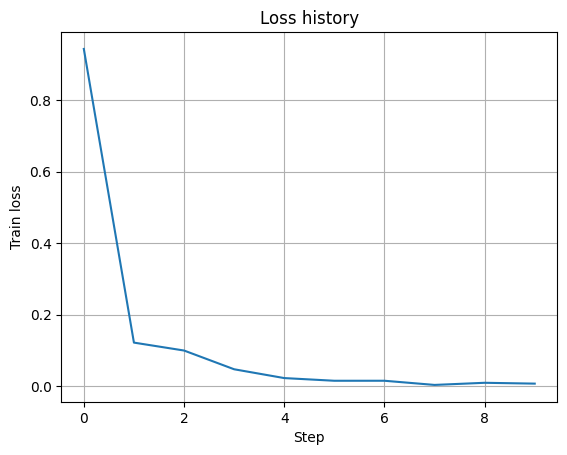

In [29]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history);

In [30]:
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Для увеличения точности изменяла максимальную длинну и количество эпох. Получился хороший результат, ошибка стабильно падает.